In [1]:
# Firstly, let's import packages tools we need
import pandas as pd
import matplotlib.pyplot as plt
import geopandas
from shapely.geometry import Point 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
pd.set_option('precision', 3)          # this tells pandas to print out 3 decimal places when we print a DataFrame
import numpy as np
import patsy                           # provides a syntax for specifying models  
import statsmodels.api as sm           # provides statistical models like ols, gmm, anova, etc...
import statsmodels.formula.api as smf 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import datetime as dt   # Data types and methods for dealing with dates and time. Name it dt for short.
from statsmodels.iolib.summary2 import summary_col
import csv

# This following is a jupyter magic command. 
# It tells jupyter to insert the plots into the notebook rather than a new window.
%matplotlib inline      

# Deal with states' data

## 1. Data about age, personal income and internet accessibility

In [2]:
# List the file names of all states' data
states = ['1_Alabama','2_Alaska','3_Arizona','4_Arkansas','5_California','6_7_Colorado_Connecticut',
          '8_Delaware','9_Mississippi','10_11_Florida_Georgia','12_13_Hawaii_Idaho','14_Illinois', 
          '15_16_17_18_19_Indiana_Iowa_Kansas_Kentucky_Louisiana','20_21_22_Maine_Maryland_Massachusetts',
          '23_24_Michigan_Minnesota','25_Missouri','26_Montana','27_Nebraska','28_Nevada','29_New Hampshire',
          '30_New Jersey','31_New Mexico','32_New York','33_North Carolina','34_North Dakota','35_Ohio',
          '36_Oklahoma','37_Oregon','38_Pennsylvania','39_Rhode Island','40_South Carolina','41_South Dakota',
          '42_Tennessee','43_Texas','44_Utah','45_46_Vermont_Virginia','47_Washington','48_West Virginia',
          '49_Wisconsin','50_Wyoming']

In [3]:
# Import all files about states' data
state = []
for var in states:
    state.append(pd.read_csv('states_income/'+var+'/'+var+'.csv'))

In [4]:
# Keep useful columns and rename them
for i in range(0,len(state)):
    state[i] = state[i][['PINCP','AGEP','ACCESS','ST']]
    state[i] = state[i].rename(columns={'PINCP':'income_person', 'AGEP':'age',
                                             'ACCESS':'inter_access','ST':'state'})

In [5]:
# Combine all dataframes vertically
state_combined = state[0]
for i in range(1, len(state)):
    state_combined = pd.concat([state_combined,state[i]], ignore_index=True)

In [6]:
state_combined.head()

,income_person,age,inter_access,state
0,-1500,19,0,1
1,1600,18,0,1
2,10000,53,0,1
3,0,28,0,1
4,0,38,0,1


In [7]:
# Read file containing states'names and fips
states_fips = pd.read_excel('state-geocodes-v2018.xlsx', skiprows=5, usecols=[2,3])

In [8]:
# Keep rows containing states'names and fips
delete_code = 'Region|Division|Columbia'
states_fips = states_fips[~states_fips['Name'].str.contains(delete_code)]

In [9]:
# Merge dataframes and keep columns we need, and rename them
state_combined = pd.merge(state_combined, states_fips, left_on='state',
                          right_on='State (FIPS)', how='outer')
state_combined = state_combined.drop('state', axis=1)
state_combined.rename(columns={'State (FIPS)':'fips', 'Name':'state'}, inplace=True)

In [10]:
# Make inter_access data more understandable by replacing numbers with real meanings
inter_access_code = {0: 'N/A', 1: 'yes', 2: 'yes', 3: 'No access'}

state_combined['inter_access'] = state_combined['inter_access'].replace(inter_access_code)

In [11]:
# Check the replacement result
print(state_combined['inter_access'].unique())

['N/A' 'yes' 'No access']


In [12]:
state_combined.sample(5)

,income_person,age,inter_access,fips,state
2390849,39400,74,yes,41,Oregon
1017007,500,16,yes,17,Illinois
2396163,2500,19,N/A,42,Pennsylvania
1563187,4000,25,yes,26,Michigan
2315379,-19999,6,yes,40,Oklahoma


In [13]:
# Only keep rows about people between 24 and 65 years old who are the major labor force
age_con = (state_combined['age']>24) & (state_combined['age']<65)
state_work = state_combined[age_con]

In [14]:
# Define a function to measure income inequality
def income_diff(x):
    """
    Input a series of incomes. Return the income inequality.
    """
    a = x.quantile(0.9)
    b = x.quantile(0.1)
    c = x.where(x>a).sum()   # Sum of the top 10% people's incomes
    d = x.where(x<b).sum()   # Sum of the bottom 10% people's incomes 
    e = x.sum()              # Sum of incomes of all people
    
    # the ratio of top 10% incomes in total incomes minus the ratio of bottom 10% incomes in total incomes
    diff_ratio = c/e - d/e     
    
    return diff_ratio*100

In [15]:
# Define a function to calculate the ratio of having internet access
def inter_access_ratio(x):
    """
    Input a series of internet access conditions. Return the internet access ratio.
    """
    a = x.value_counts()
    b = a.at['yes']  # The number of people who have internet access
    c = x.count()    # The number of total people
    
    return b/c*100  

In [16]:
# Use the income_diff function to calculate the income inequality within each state
income_diff = state_work[['state', 'income_person']].groupby('state').agg(income_diff)

/Users/wuyumeng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


In [17]:
income_diff.columns=['income_diff']

In [18]:
# Use the defined function to calculate the internet access ratio within each state
inter_ratio = state_work[['state', 'inter_access']].groupby('state').agg(inter_access_ratio)

In [19]:
inter_ratio.columns=['inter_ratio']

## 2. Data about educational attainment

In [20]:
# Read file
education=pd.read_excel('education18.xls',skiprows=4)

In [21]:
# Keep useful columns and rename them
education = education[['Area name','Percent of adults with a bachelor\'s degree or higher, 2014-18']]
educ_ratio = education.rename(columns={'Area name':'state',
                           'Percent of adults with a bachelor\'s degree or higher, 2014-18':'edu_ratio'})

# Correct a spelling error about a state's name
educ_ratio['state'] = educ_ratio['state'].replace({'Lousiana':'Louisiana'})

In [22]:
# Get a list of the names of 50 states
state_list = states_fips['Name'].tolist()

# Keep rows containing 50 states' data
educ_ratio = educ_ratio[educ_ratio['state'].isin(state_list)]

## 3. Data about GDP

In [23]:
# Read the file with gdp growth rate
gdp_gr=pd.read_csv('rgdp_gr_state.csv', skiprows=4)

In [24]:
# Keep useful columns and rename them
gdp_gr = gdp_gr.drop('GeoFips',axis=1)
gdp_gr = gdp_gr.rename(columns={'GeoName':'state','2017-2018':'gdp_gr'})
# Keep useful 50 states' data
gdp_gr = gdp_gr[gdp_gr['state'].isin(state_list)]

**We calculate GDP per capita by dividing real GDP by total population**

In [25]:
# Read the file with real GDP
gdp = pd.read_csv('rgdp_state.csv',skiprows=4)

In [26]:
# Keep useful columns and rename them
gdp=gdp.drop('GeoFips',axis=1)
gdp = gdp.rename(columns={'GeoName':'state','2018':'gdp'})

# Keep useful 50 states' data
gdp = gdp[gdp['state'].isin(state_list)]

In [27]:
# Read the file with population
pop = pd.read_excel('population_state.xlsx',skiprows=3, usecols=[0,11], skipfooter=7)

In [28]:
# Rename columns, clean data and keep useful rows
pop.columns=['state','population']
pop['state']=pop['state'].str.strip('.')
pop = pop[pop['state'].isin(state_list)]

In [29]:
# Merge dataframes and calculate GDP per capita
gdp_pc = pd.merge(left=gdp, right=pop, on='state', how='outer')
gdp_pc['gdp_pc']=gdp_pc['gdp']/gdp_pc['population']*1000  # Set GDP per capita in thousands dollors

In [30]:
# Get the columns we need
gdp_pc = gdp_pc[['state', 'gdp_pc']]

## 4. Data about demographics

In [31]:
# Read the file
census = pd.read_csv('states_demo.csv')

In [32]:
# Keep useful columns and rename them
census = census[['NAME', 'SEX', 'RACE', 'AGE', 'POPESTIMATE2018']]
census.rename(columns={'NAME':'state','POPESTIMATE2018':'population'}, inplace=True)

# Keep data about people between 24 and 65 years old who are the major labor force
census = census[(census['AGE']<65) & (census['AGE']>24)] 

# SEX==0 means all population containing females and males
census = census[census['SEX']==0]

In [33]:
# Calculate the total population in each state
total_pop = census[['state', 'population']].groupby('state').sum()
total_pop.rename(columns={'population':'total_pop'},inplace=True)
total_pop.reset_index(inplace=True)

# RACE==1 means white people and 2 means black people
white = census[census['RACE']==1]
black = census[census['RACE']==2]

In [34]:
race_pop = [0,1]
race = total_pop
for i, var in enumerate([white, black]):
    
    # Calculate the total white population/black population in each state
    
    race_pop[i] = var[['state', 'population']].groupby('state').sum()
    race_pop[i].rename(columns={'population':'Race='+str(i+1)+'_pop'},inplace=True)
    race_pop[i].reset_index(inplace=True)
    
    # Merge dataframes about total& white & black population
    race = pd.merge(left=race, right=race_pop[i], on='state', how='outer')
    
    # Calculate the ratio of white/black population in total population
    race['Race='+str(i+1)+'_ratio'] = race['Race='+str(i+1)+'_pop']/race['total_pop']*100

In [35]:
# Rename columns we need to use later
race = race.rename(columns={'Race=1_ratio':'white_ratio', 'Race=2_ratio':'black_ratio'})

# Get the columns we need 
race = race[['state', 'white_ratio', 'black_ratio']]

## 5. Data about unemployment rate

In [36]:
unemp = pd.read_excel('states_unemploy18.xlsx', usecols=[0,1])

In [37]:
# Keep data about 50 states and rename columns
unemp=unemp[unemp['State'].isin(state_list)]
unemp.columns=['state','unemp_rate']

# Correct the type of unemployment rate to float
unemp['unemp_rate']=unemp['unemp_rate'].astype(float)

## 6. Merge all dataframes containing data we need

In [38]:
dataframes = [income_diff, inter_ratio, educ_ratio, gdp_gr, gdp_pc, race, unemp]
for i in range(6):
    dataframes[i+1] = pd.merge(left=dataframes[i], right=dataframes[i+1],on='state', how='inner')

In [39]:
all_states = dataframes[6]    # Obtain the final dataframe after merging
all_states

,state,income_diff,inter_ratio,edu_ratio,gdp_gr,gdp_pc,white_ratio,black_ratio,unemp_rate
0,Alabama,38.261,86.798,24.9,2.3,40.521,69.227,27.135,3.9
1,Alaska,35.438,81.265,29.2,0.2,71.998,69.091,3.820,6.5
2,Arizona,36.308,88.075,28.9,3.9,43.869,82.736,5.393,4.7
3,Arkansas,38.080,85.808,22.6,1.5,38.774,79.602,15.714,3.6
4,California,41.267,92.312,33.3,3.1,68.648,71.435,6.705,4.3
5,Colorado,36.966,93.670,40.1,4.4,60.244,87.644,4.619,3.2
6,Connecticut,41.890,93.261,38.9,0.4,69.730,79.893,12.322,4.1
7,Delaware,36.789,92.150,31.4,2.1,65.421,69.560,23.301,3.8
8,Florida,40.804,91.918,29.2,3.8,44.086,77.203,17.206,3.6
9,Georgia,40.103,89.995,30.7,3.7,51.253,60.358,32.818,3.9


## 7. Plotting

In [40]:
# load map information
states_geo = geopandas.read_file('cb_2018_us_state_5m/cb_2018_us_state_5m.shp')
states_geo = states_geo.to_crs({'init': 'epsg:3395'})  # change the projection method to see Mercator projected maps

/Users/wuyumeng/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [41]:
# Get the geometry of lower 48 states
states_50 = states_geo[states_geo['NAME'].isin(state_list)]
lower_48 = states_50[~states_50['NAME'].isin(['Hawaii', 'Alaska'])]

In [42]:
# merge dataframes together
lower48 = pd.merge(left=lower_48, right=all_states[['state','income_diff','gdp_pc']], 
                   left_on='NAME',right_on='state', how='inner')

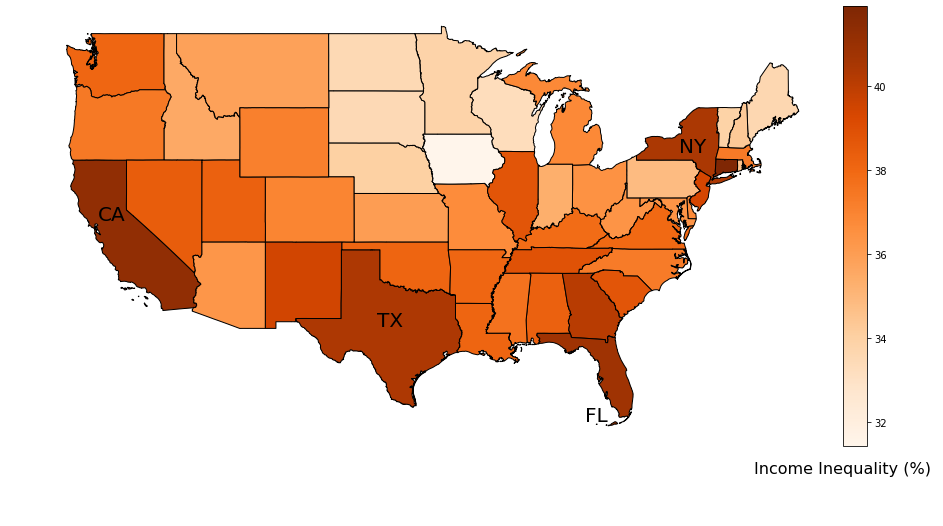

In [43]:
# Plot income inequality by state
fig,gax=plt.subplots(figsize=(15,10))

divider = make_axes_locatable(gax)
legend_ax = divider.append_axes('right', size='3%', pad=0.1)

lower48.plot(ax=gax, edgecolor='black',column='income_diff', cmap='Oranges', legend=True, cax=legend_ax)

gax.annotate('Income Inequality (%)', fontsize=16, xy=(0.8,0.1), xycoords='figure fraction')
gax.annotate('CA', xy=(0.104,0.58), xycoords='figure fraction', fontsize=20)
gax.annotate('TX', xy=(0.4,0.38), xycoords='figure fraction', fontsize=20)
gax.annotate('NY', xy=(0.72,0.71), xycoords='figure fraction', fontsize=20)
gax.annotate('FL', xy=(0.62,0.2), xycoords='figure fraction', fontsize=20)

gax.axis('off')

plt.savefig('map_income_diff.svg',  bbox_inches='tight')

plt.show()

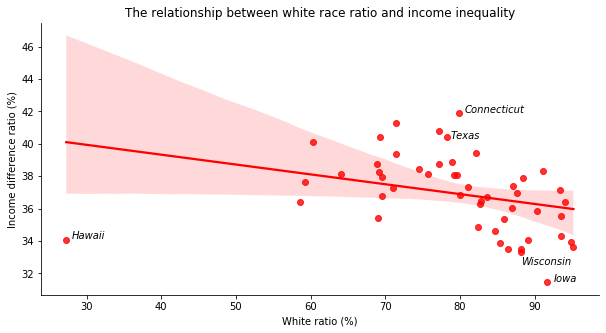

In [44]:
# Plot the relationship between white race ratio and income inequality
my_fig, my_ax = plt.subplots(figsize=(10,5)) 

sns.regplot(x='white_ratio',                                       
            y='income_diff',                                      
            data=all_states,   
            ax = my_ax,                                         
            color = 'red',                                  
            ci = 95)                                             

sns.despine(ax = my_ax)                             

my_ax.set_title('The relationship between white race ratio and income inequality')
my_ax.set_ylabel('Income difference ratio (%)')
my_ax.set_xlabel('White ratio (%)')
    
my_ax.text(92.5, 31.5, 'Iowa',  style="italic") 
my_ax.text(78.7, 40.3, 'Texas',  style="italic") 
my_ax.text(28, 34.1, 'Hawaii',  style="italic") 
my_ax.text(80.6, 41.9, 'Connecticut',  style="italic") 
my_ax.text(88.182, 32.5, 'Wisconsin',  style="italic") 

plt.savefig('white.svg')

plt.show()

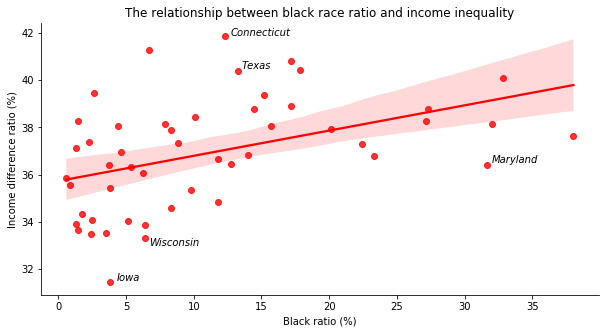

In [45]:
# Plot the relationship between black race ratio and income inequality
my_fig, my_ax = plt.subplots(figsize=(10,5)) 

sns.regplot(x='black_ratio',                                       
            y='income_diff',                                      
            data=all_states,   
            ax = my_ax,                                         
            color = 'red',                                  
            ci = 95)                                             

sns.despine(ax = my_ax)                             

my_ax.set_title('The relationship between black race ratio and income inequality')
my_ax.set_ylabel('Income difference ratio (%)')
my_ax.set_xlabel('Black ratio (%)')

my_ax.text(4.3, 31.5, 'Iowa',  style="italic") 
my_ax.text(13.5, 40.5, 'Texas',  style="italic") 
my_ax.text(12.7, 41.9, 'Connecticut',  style="italic") 
my_ax.text(32, 36.5, 'Maryland',  style="italic") 
my_ax.text(6.7, 33, 'Wisconsin',  style="italic")

plt.savefig('black.svg')

plt.show()

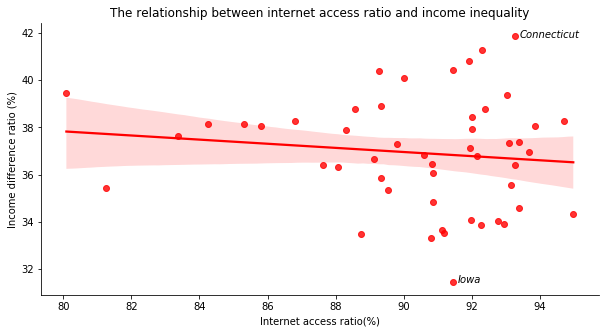

In [46]:
# Plot the relationship between internet access ratio and income inequality
my_fig, my_ax = plt.subplots(figsize=(10,5)) 

sns.regplot(x='inter_ratio',                                       
            y='income_diff',                                      
            data=all_states,   
            ax = my_ax,                                         
            color = 'red',                                  
            ci = 95)                                             

sns.despine(ax = my_ax)                             

my_ax.set_title('The relationship between internet access ratio and income inequality')
my_ax.set_ylabel('Income difference ratio (%)')
my_ax.set_xlabel('Internet access ratio(%)')
    
my_ax.text(91.6, 31.4, 'Iowa',  style="italic") 
my_ax.text(93.4, 41.8, 'Connecticut',  style="italic") 

plt.savefig('internet.svg')
plt.show()

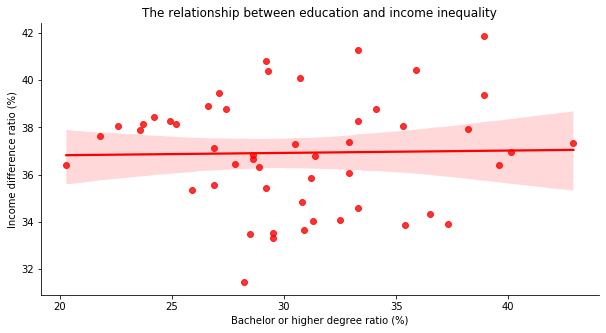

In [47]:
# Plot the relationship between education and income inequality
my_fig, my_ax = plt.subplots(figsize=(10,5)) 

sns.regplot(x='edu_ratio',                                       
            y='income_diff',                                      
            data=all_states,   
            ax = my_ax,                                         
            color = 'red',                                  
            ci = 95)                                             

sns.despine(ax = my_ax)                             

my_ax.set_title('The relationship between education and income inequality')
my_ax.set_ylabel('Income difference ratio (%)')
my_ax.set_xlabel('Bachelor or higher degree ratio (%)')


plt.savefig('education.svg')
plt.show()

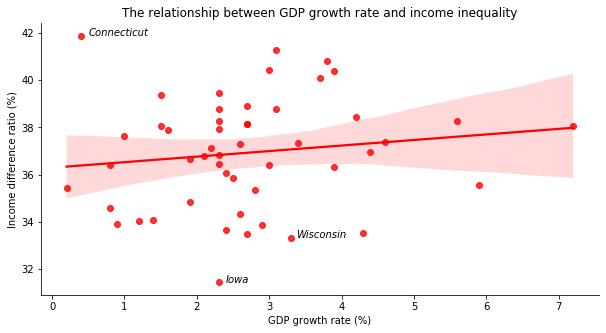

In [96]:
# Plot the relationship between GDP growth rate and income inequality
my_fig, my_ax = plt.subplots(figsize=(10,5)) 

sns.regplot(x='gdp_gr',                                       
            y='income_diff',                                      
            data=all_states,   
            ax = my_ax,                                         
            color = 'red',                                  
            ci = 95)                                             

sns.despine(ax = my_ax)                             

my_ax.set_title('The relationship between GDP growth rate and income inequality')
my_ax.set_ylabel('Income difference ratio (%)')
my_ax.set_xlabel('GDP growth rate (%)')

my_ax.text(0.5, 41.9, 'Connecticut',  style="italic") 
my_ax.text(2.4, 31.4, 'Iowa',  style="italic") 
my_ax.text(3.37, 33.322, 'Wisconsin',  style="italic") 

plt.savefig('growthrate.svg')
plt.show()

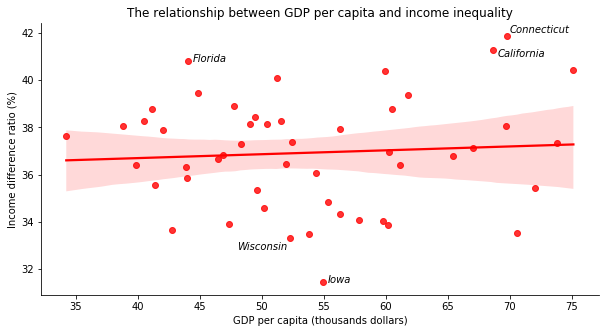

In [49]:
# Plot the relationship between GDP per capita and income inequality
my_fig, my_ax = plt.subplots(figsize=(10,5)) 

sns.regplot(x='gdp_pc',                                       
            y='income_diff',                                      
            data=all_states, 
            ax = my_ax,                                         
            color = 'red',                                  
            ci = 95)                                             

sns.despine(ax = my_ax)                             

my_ax.set_title('The relationship between GDP per capita and income inequality')
my_ax.set_ylabel('Income difference ratio (%)')
my_ax.set_xlabel('GDP per capita (thousands dollars)')

my_ax.text(69, 41, 'California',  style="italic") 
my_ax.text(70, 42, 'Connecticut',  style="italic") 
my_ax.text(55.3, 31.4, 'Iowa',  style="italic") 
my_ax.text(44.4, 40.8, 'Florida',  style="italic") 
my_ax.text(48, 32.8, 'Wisconsin',  style="italic")

plt.savefig('gdpc.svg')
plt.show()

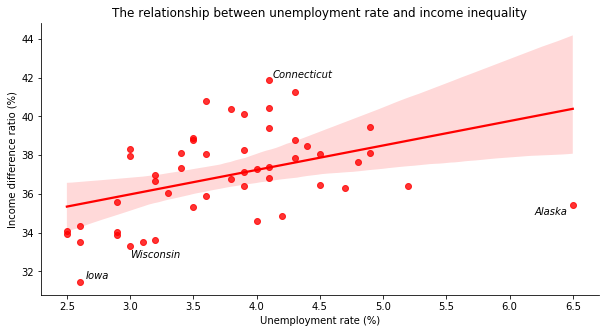

In [50]:
# Plot the relationship between unemployment rate and income inequality
my_fig, my_ax = plt.subplots(figsize=(10,5)) 

sns.regplot(x='unemp_rate',                                       
            y='income_diff',                                      
            data=all_states,  
            ax = my_ax,                                         
            color = 'red',                                  
            ci = 95)                                             

sns.despine(ax = my_ax)                             

my_ax.set_title('The relationship between unemployment rate and income inequality')
my_ax.set_ylabel('Income difference ratio (%)')
my_ax.set_xlabel('Unemployment rate (%)')

my_ax.text(2.65, 31.6, 'Iowa',  style="italic") 
my_ax.text(4.13, 42, 'Connecticut',  style="italic") 
my_ax.text(6.2, 34.9, 'Alaska',  style="italic") 
my_ax.text(3, 32.7, 'Wisconsin',  style="italic")

plt.savefig('unem.svg')

plt.show()

In [51]:
# regress on income_diff using ols
res_state=smf.ols('income_diff~white_ratio+black_ratio+inter_ratio+edu_ratio+gdp_gr+gdp_pc+unemp_rate',data=all_states).fit()
print(res_state.summary()) 

                            OLS Regression Results                            
Dep. Variable:            income_diff   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     4.264
Date:                Fri, 11 Dec 2020   Prob (F-statistic):            0.00123
Time:                        19:31:25   Log-Likelihood:                -99.546
No. Observations:                  50   AIC:                             215.1
Df Residuals:                      42   BIC:                             230.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      29.8895     11.580      2.581      

In [52]:
table_1 = summary_col(
    res_state, 
    model_names = ['income difference ratio'],
    stars=True, 
    regressor_order = ['Intercept', 'white_ratio', 'black_ratio', 'inter_ratio',
                       'edu_ratio','gdp_gr','gdp_pc','unemp_rate'],
    float_format='%0.2f',
    drop_omitted = True
    )

table_1.add_title('Income Inequality')
table_1.add_text('More text to append.')

print(table_1.as_text())

         Income Inequality
            income difference ratio
-----------------------------------
Intercept   29.89**                
            (11.58)                
white_ratio -0.01                  
            (0.03)                 
black_ratio 0.09**                 
            (0.04)                 
inter_ratio -0.02                  
            (0.14)                 
edu_ratio   0.10                   
            (0.09)                 
gdp_gr      0.52**                 
            (0.22)                 
gdp_pc      -0.00                  
            (0.04)                 
unemp_rate  1.21***                
            (0.44)                 
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
More text to append.


In [53]:
fout = open('table1.html', 'w')
fout.write(table_1.as_html())
fout.close()

# Deal with 27 districts' data in WI

In [54]:
# List all the files' names
districts = ['1_Dane', '2_Sheboygan', '3_Rock', '4_La Crosse', '5_Winnebago', '6_Marathon',
            '7_Walworth', '8_Kenosha', '9_Waukesha', '10_Milwaukee_city', '10_Milwaukee_county',
            '11_Racine','12_Washington_Ozaukee', '13_Outagamie', '14_Dodge_Jefferson', 
            '15_Sauk_Columbia', '16_Manitowoc_Kewaunee', '17_Marinette_Oconto_Door_Florence',
            '18_Oneida_Lincoln_Vilas_Langlade_Forest', '19_St. Croix_Dunn', 
             '20_Wood_Portage_Juneau_Adams', '21_Eau Claire_Chippewa_Barron_Polk_Clark',
            '22_Fond du Lac_Calumet', '23_Grant_Green_Iowa_Richland_Lafayette',
            '24_Brown', '25_Menominee_Shawano_Waupaca_Waushara_Marquette_Green Lake',
            '26_Douglas_Bayfield_Burnett_Washburn_Sawyer_Iron_Ashland_Price_Rusk_Taylor',
            '27_Pierce_Pepin_Buffalo_Jackson_Trempealeau_Monroe_Vernon_Crawford']

# Read all the files and put all the dataframes in a list
district = []
for var in districts:
    district.append(pd.read_csv('WI/'+var+'/'+var+'.csv'))

# Keep the columns we need and rename them
for i in range(28):
    district[i] = district[i].drop(['PWGTP', 'WGTP', 'PUMA', 'Unnamed: 10'], axis=1)
    district[i] = district[i].rename(columns={'PINCP':'income_person', 'AGEP':'age',
                                             'RAC1P':'race', 'ACCESS':'inter_access',
                                             'SEX':'sex', 'SCHL':'edu_attain', 'ST':'state'})

In [55]:
# Extract the districts' names from the files' names
district_name = []
for var in districts:
    district_name.append(var.split('_',1)[-1])

In [56]:
# Add a new column showing the district name in every dataframe
for i, var in enumerate(district_name):
    district[i]['district'] = var

# Combine Milwaukee city and Milwaukee county to a district named Milwaukee
district[9]['district'] = 'Milwaukee'
district[10]['district'] = 'Milwaukee'

In [57]:
# Combine all data in dataframes vertically and we get all data in 27 districts
all_districts = district[0]
for i in range(1, len(district)):
    all_districts = pd.concat([all_districts,district[i]],axis=0,ignore_index=True)

# Correct the data type
all_districts = all_districts.astype({'income_person':'float64','age':'int64','race':'int64', 
                                      'inter_access':'int64', 'sex': 'int64', 'edu_attain':
                                      'int64', 'state':'int64'})

In [58]:
# Interpret the number in each column
race_code = {1:'white',2:'black_or_African American', 3: 'others',4: 'others',
             5: 'others', 6: 'others', 7: 'others', 8: 'others', 9:'others'}

inter_access_code = {0: 'N/A', 1: 'yes', 2: 'yes', 3: 'No access'}

sex_code = {1:'male',  2:'female'}

edu_attain_code = {0: 'N/A', 1: 'No schooling completed', 2: 'Nursery school, preschool', 
                   3:'Primary', 4:'Primary',  5:'Primary', 6:'Primary', 
                   7:'Primary', 8:'Primary', 9:'Middle', 10:'Middle', 11:'Middle',
                   12:'High', 13:'High', 14:'High',  15:'High', 16:'High',
                   17:'pre_college', 18:'short_college', 19:'short_college',
                   20:'Associate', 21:'Bachelor or higher', 22:'Bachelor or higher',
                   23:'Bachelor or higher',24:'Bachelor or higher'}

In [59]:
# Replace the number in each column with actual meanings for easy understanding
all_districts['race'] = all_districts['race'].replace(race_code)
all_districts['inter_access'] = all_districts['inter_access'].replace(inter_access_code)
all_districts['sex'] = all_districts['sex'].replace(sex_code)
all_districts['edu_attain'] = all_districts['edu_attain'].replace(edu_attain_code)

In [60]:
# Keep data about people between 24 and 65 years old
age_condi = (all_districts['age']>24) & (all_districts['age']<65)
all_dist_work = all_districts[age_condi]

In [61]:
# Define a function to measure income inequality
def income_inequality(x):
    """
    Input a series of incomes. Return the income inequality.
    """
    a = x.quantile(0.9)
    b = x.quantile(0.1)
    c = x.where(x>a).sum()                # Sum of the top 10% people's incomes
    d = x.where(x<b).sum()                # Sum of the bottom 10% people's incomes 
    e = x.sum()                           # Sum of incomes of all people
    
    # the ratio of top 10% incomes in total incomes minus the ratio of bottom 10% incomes in total incomes
    income_diff_ratio = c/e - d/e     
    
    return income_diff_ratio*100

# Define a function to calculate the ratio of white population in total population
def white_ratio(x):
    """
    Input a series of individual race data. Return the white ratio in total population.
    """
    a = x.value_counts()
    b = a.at['white']                      # The number of white people
    c = x.count()                          # The number of total people
    return b/c*100

# Define a function to calculate the ratio of black population in total population
def black_ratio(x):
    """
    Input a series of individual race data. Return the black ratio in total population.
    """
    a = x.value_counts()
    b = a.at['black_or_African American']   # The number of white people
    c = x.count()                           # The number of total people
    return b/c*100

# Define a function to calculate the ratio of the number of people who have bachelor's degree or higher in total population
def edu_ratio(x):
    """
    Input a series of individual educational attainment data.
    Return the ratio of the number of people who have bachelor's degree or higher in total population.
    """
    a = x.value_counts()
    b = a.at['Bachelor or higher']           # people who have bachelor's degree or higher
    c = x.count()                            # The number of total people
    return b/c*100

In [62]:
# Use the defined functions to calculate corresponding variables in each district using groupby
income_group = all_dist_work[['district', 'income_person']].groupby('district').agg(income_inequality)
white_group = all_dist_work[['district', 'race']].groupby('district').agg(white_ratio)
black_group = all_dist_work[['district', 'race']].groupby('district').agg(black_ratio)
inter_group = all_dist_work[['district', 'inter_access']].groupby('district').agg(inter_access_ratio)
edu_group = all_dist_work[['district', 'edu_attain']].groupby('district').agg(edu_ratio)

# Merge all data in different dataframe by using for loop
group = [income_group, white_group, black_group, inter_group, edu_group]
for i in range(4):
    group[i+1] = pd.merge(left=group[i], right=group[i+1], left_on='district', right_on='district',
                how='outer')

# Obtain the final dataframe after merging
dist_group = group[4]

# Rename some columns
dist_group = dist_group.rename(columns={'income_person':'income_diff',
                                        'race_x':'white_ratio',
                                        'race_y':'black_ratio',
                                       'inter_access':'inter_ratio',
                                       'edu_attain':'edu_ratio'})

/Users/wuyumeng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


**Data about unemployment rate and GDP**

In [63]:
# Read file containing unemployment rate data
unemp = pd.read_excel('employment18.xlsx', usecols=[3,9], skiprows=5, skipfooter=3)
unemp.columns = ['county','unemp_rate']

# Extract data about Wisconsin
unemp_wi = unemp[unemp['county'].str.contains('WI')]
unemp_wi['county'] = [var[:-11] for var in unemp_wi['county']]

/Users/wuyumeng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [64]:
# Read file containing GDP data
gdp = pd.read_excel('gdp_wi_18.xlsx', usecols=[0,7,15], skiprows=2 )
gdp.columns = ['county','gdp_gr','gdp_pc']

# Merge unemployment rate and GDP data
gdp_emp = pd.merge(left=gdp, right=unemp_wi,on='county',how='outer') 

In [65]:
# Define a function to create a distionary between county' names and district' names
def generateDic(county, district):
    """
    Input two lists. Return a dictionary between two lists correspondingly.
    """
    c_d = {}
    for county_name in county:
        for district_name in district:
            if county_name in district_name:
                c_d[county_name] = district_name
    return c_d

In [66]:
# Obtain a list of districts' names
district_list = dist_group.index.to_list()

# Obtain a list of counties' names
county_list = gdp_emp['county'].to_list()

In [67]:
# Use the defined function to produce a distionary between county' names and district' names
county_district = generateDic(county_list, district_list)

# Replace the county name with the district name
gdp_emp['district'] = gdp_emp['county'].replace(county_district)

In [68]:
# Average the variables in the same district by using groupby
gdp_emp_dist = gdp_emp.groupby('district').mean()

# Merge dataframes containing all the districts' data we need
dist_group_merge = pd.merge(left=dist_group, right=gdp_emp_dist,
                            on='district',
                            how='left')

In [69]:
dist_group_merge

,income_diff,white_ratio,black_ratio,inter_ratio,edu_ratio,gdp_gr,gdp_pc,unemp_rate
district,,,,,,,,
Brown,31.299,89.335,2.638,89.106,29.128,2.600,64.084,2.700
Dane,35.628,89.565,3.478,93.657,51.662,2.200,75.907,2.200
Dodge_Jefferson,33.161,95.199,2.585,91.043,24.838,3.000,42.978,2.750
Douglas_Bayfield_Burnett_Washburn_Sawyer_Iron_Ashland_Price_Rusk_Taylor,32.138,94.649,0.606,89.551,21.807,1.630,35.960,4.260
Eau Claire_Chippewa_Barron_Polk_Clark,33.268,96.571,1.093,88.917,18.887,2.460,42.670,3.180
Fond du Lac_Calumet,28.312,96.725,1.092,92.467,23.690,2.000,38.770,2.600
Grant_Green_Iowa_Richland_Lafayette,31.026,97.744,0.265,90.776,24.419,1.075,41.042,2.575
Kenosha,31.045,90.909,3.598,94.129,29.545,-0.600,36.357,3.500
La Crosse,34.296,94.878,1.559,92.873,39.421,2.700,54.815,2.600


## Plotting

In [70]:
# Read map file about states and counties
states = geopandas.read_file('cb_2018_us_state_5m/cb_2018_us_state_5m.shp')
counties = geopandas.read_file('cb_2018_us_county_5m/cb_2018_us_county_5m.shp')

wi_counties = counties[counties['STATEFP']=='55']  # Extract data about Wisconsin

# Change the projection of our figures
states=states.to_crs({'init': 'epsg:3395'})
wi_counties = wi_counties.to_crs({'init': 'epsg:3395'}) 

# Clean data format and change the county name to district name
wi_counties['NAME'] = wi_counties['NAME'].str.title()
wi_counties['NAME'] = wi_counties['NAME'].replace(county_district)

# Correct a spelling error in the NAME
wi_counties['NAME'] = wi_counties['NAME'].replace({'Fond Du Lac':'Fond du Lac_Calumet'})

# Merge the geometry with the dataframe containing the data used to plot Choropleth map
dist_group_merge.reset_index(inplace=True)
income_gdp_merged = pd.merge(left=wi_counties, 
                             right=dist_group_merge[['district','income_diff','gdp_pc']],
                             left_on='NAME', right_on='district',
                             how='outer')

/Users/wuyumeng/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


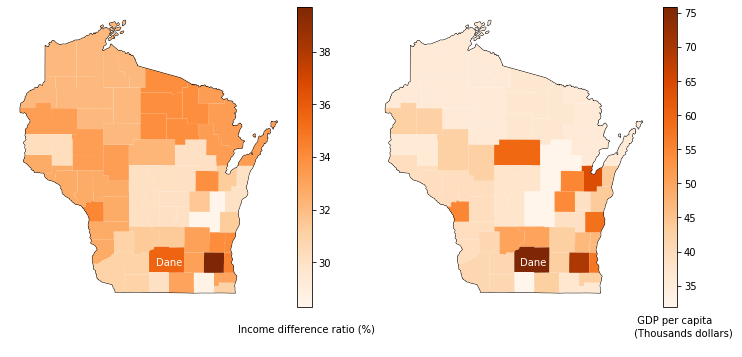

In [71]:
fig, gax = plt.subplots(1,2,figsize=(12,6))

states[states['NAME'] == 'Wisconsin'].plot(ax=gax[0], edgecolor='black',color='white')
states[states['NAME'] == 'Wisconsin'].plot(ax=gax[1], edgecolor='black',color='white')


divider0 = make_axes_locatable(gax[0])

legend_ax0 = divider0.append_axes('right', size='5%', pad=0.1)

income_gdp_merged.plot(
             ax = gax[0], column='income_diff',           
             edgecolor='grey', cmap = 'Oranges', linewidth=0, 
             legend=True, cax=legend_ax0)           
divider1 = make_axes_locatable(gax[1])
legend_ax1 = divider1.append_axes('right', size='5%', pad=0.1)
income_gdp_merged.plot(
             ax = gax[1], column='gdp_pc',           
             edgecolor='grey', cmap = 'Oranges', linewidth=0, 
             legend=True, cax=legend_ax1)  

gax[0].annotate('Income difference ratio (%)', xy=(0.32,0.07), xycoords='figure fraction')
gax[0].annotate('Dane', xy=(0.21,0.255), xycoords='figure fraction', fontsize=10, color='w')

gax[1].annotate('  GDP per capita \n (Thousands dollars)', xy=(0.85,0.06), xycoords='figure fraction')
gax[1].annotate('Dane', xy=(0.7,0.255), xycoords='figure fraction', fontsize=10, color='w')

gax[0].axis('off')
gax[1].axis('off')

plt.savefig('map_wi.svg',  bbox_inches='tight')
plt.show()

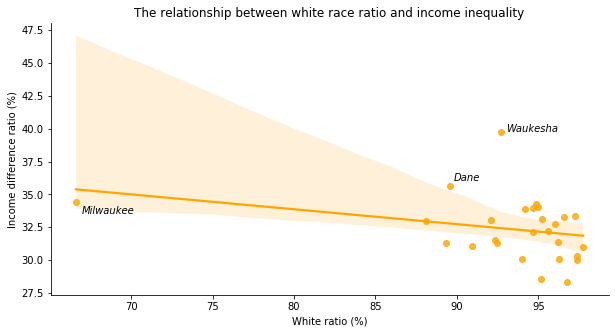

In [72]:
# Plot the relationship between white race ratio and income inequality
my_fig, my_ax = plt.subplots(figsize=(10,5)) 

sns.regplot(x='white_ratio',                                       
            y='income_diff',                                      
            data=dist_group_merge,   
            ax = my_ax,                                         
            color = 'orange',                                  
            ci = 95)                                             

sns.despine(ax = my_ax)                             

my_ax.set_title('The relationship between white race ratio and income inequality')
my_ax.set_ylabel('Income difference ratio (%)')
my_ax.set_xlabel('White ratio (%)')

my_ax.text(67,33.5,'Milwaukee',style="italic")
my_ax.text(93,39.8,'Waukesha',style="italic")
my_ax.text(89.8,36,'Dane',style="italic")

plt.savefig('white_wi.svg')
plt.show()

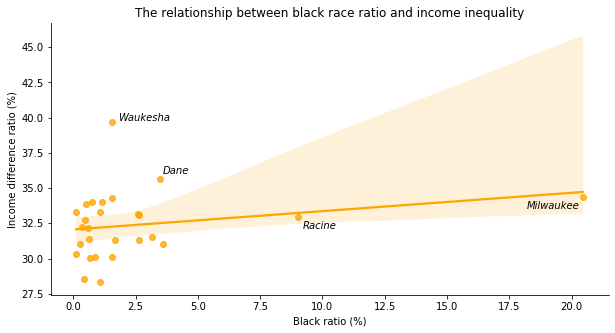

In [73]:
# Plot the relationship between black race ratio and income inequality
my_fig, my_ax = plt.subplots(figsize=(10,5)) 

sns.regplot(x='black_ratio',                                       
            y='income_diff',                                      
            data=dist_group_merge,   
            ax = my_ax,                                         
            color = 'orange',                                  
            ci = 95)                                             

sns.despine(ax = my_ax)                             

my_ax.set_title('The relationship between black race ratio and income inequality')
my_ax.set_ylabel('Income difference ratio (%)')
my_ax.set_xlabel('Black ratio (%)')

my_ax.text(18.2,33.5,'Milwaukee',style="italic")
my_ax.text(1.8,39.8,'Waukesha',style="italic")
my_ax.text(9.2,32.1,'Racine',style="italic")
my_ax.text(3.6,36,'Dane',style="italic")

plt.savefig('black_wi.svg')
plt.show()

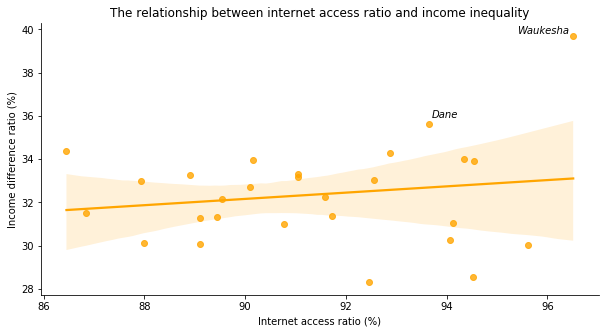

In [74]:
# Plot the relationship between internet access ratio and income inequality
my_fig, my_ax = plt.subplots(figsize=(10,5)) 

sns.regplot(x='inter_ratio',                                       
            y='income_diff',                                      
            data=dist_group_merge,   
            ax = my_ax,                                         
            color = 'orange',                                  
            ci = 95)                                             

sns.despine(ax = my_ax)                             

my_ax.set_title('The relationship between internet access ratio and income inequality')
my_ax.set_ylabel('Income difference ratio (%)')
my_ax.set_xlabel('Internet access ratio (%)')

my_ax.text(95.4,39.8,'Waukesha',style="italic")
my_ax.text(93.7,35.9,'Dane',style="italic")

plt.savefig('internet_wi.svg')
plt.show()

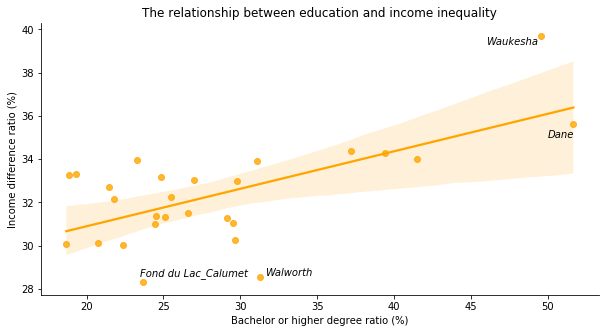

In [75]:
# Plot the relationship between education and income inequality
my_fig, my_ax = plt.subplots(figsize=(10,5)) 

sns.regplot(x='edu_ratio',                                       
            y='income_diff',                                      
            data=dist_group_merge,   
            ax = my_ax,                                         
            color = 'orange',                                  
            ci = 95)                                             

sns.despine(ax = my_ax)                             

my_ax.set_title('The relationship between education and income inequality')
my_ax.set_ylabel('Income difference ratio (%)')
my_ax.set_xlabel('Bachelor or higher degree ratio (%)')

my_ax.text(23.5,28.6,'Fond du Lac_Calumet',style="italic")
my_ax.text(31.6,28.6,'Walworth',style="italic")
my_ax.text(46,39.3,'Waukesha',style="italic")
my_ax.text(50,35,'Dane',style="italic")

plt.savefig('education_wi.svg')

plt.show()

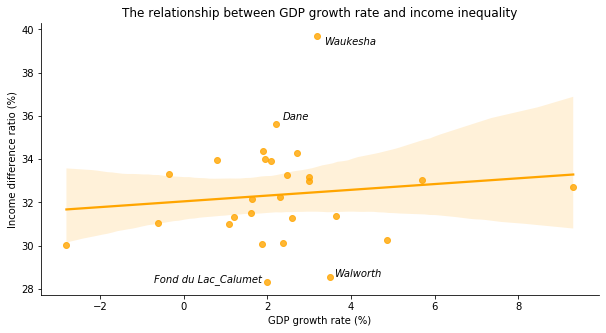

In [76]:
# Plot the relationship between GDP growth rate and income inequality
my_fig, my_ax = plt.subplots(figsize=(10,5)) 

sns.regplot(x='gdp_gr',                                       
            y='income_diff',                                      
            data=dist_group_merge,   
            ax = my_ax,                                         
            color = 'orange',                                  
            ci = 95)                                             

sns.despine(ax = my_ax)                             

my_ax.set_title('The relationship between GDP growth rate and income inequality')
my_ax.set_ylabel('Income difference ratio (%)')
my_ax.set_xlabel('GDP growth rate (%)')

my_ax.text(-0.7,28.312,'Fond du Lac_Calumet',style="italic")
my_ax.text(3.6,28.564,'Walworth',style="italic")
my_ax.text(3.35,39.3,'Waukesha',style="italic")
my_ax.text(2.37,35.8,'Dane',style="italic")

plt.savefig('gdp_gr_wi.svg')
plt.show()

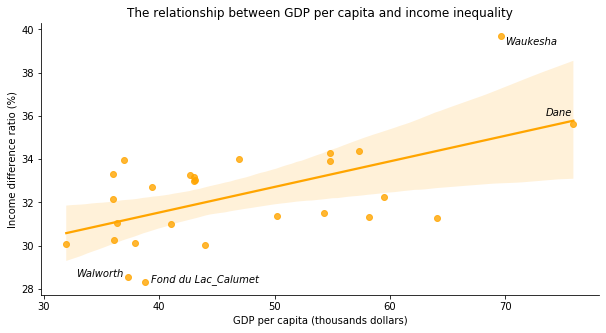

In [77]:
# Plot the relationship between GDP per capita and income inequality
my_fig, my_ax = plt.subplots(figsize=(10,5)) 

sns.regplot(x='gdp_pc',                                       
            y='income_diff',                                      
            data=dist_group_merge, 
            ax = my_ax,                                         
            color = 'orange',                                  
            ci = 95)                                             

sns.despine(ax = my_ax)                             

my_ax.set_title('The relationship between GDP per capita and income inequality')
my_ax.set_ylabel('Income difference ratio (%)')
my_ax.set_xlabel('GDP per capita (thousands dollars)')

my_ax.text(39.3,28.312,'Fond du Lac_Calumet',style="italic")
my_ax.text(32.8,28.564,'Walworth',style="italic")
my_ax.text(70,39.3,'Waukesha',style="italic")
my_ax.text(73.5,36,'Dane',style="italic")

plt.savefig('gdp_pc_wi.svg')

plt.show()

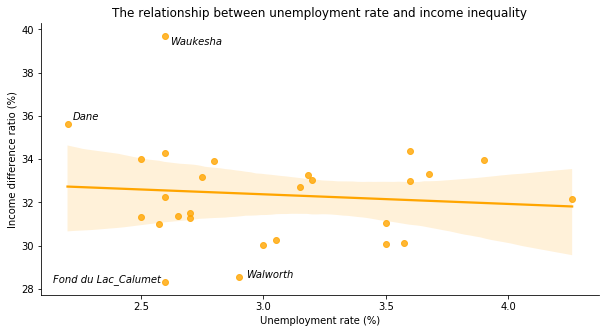

In [78]:
# Plot the relationship between unemployment rate and income inequality
my_fig, my_ax = plt.subplots(figsize=(10,5)) 

sns.regplot(x='unemp_rate',                                       
            y='income_diff',                                      
            data=dist_group_merge,  
            ax = my_ax,                                         
            color = 'orange',                                  
            ci = 95)                                             

sns.despine(ax = my_ax)                             

my_ax.set_title('The relationship between unemployment rate and income inequality')
my_ax.set_ylabel('Income difference ratio (%)')
my_ax.set_xlabel('Unemployment rate (%)')

my_ax.text(2.14,28.312,'Fond du Lac_Calumet',style="italic")
my_ax.text(2.93,28.5,'Walworth',style="italic")
my_ax.text(2.62,39.3,'Waukesha',style="italic")
my_ax.text(2.22,35.8,'Dane',style="italic")

plt.savefig('unemp_wi.svg')

plt.show()

In [79]:
# regress on income_diff using ols
res = smf.ols('income_diff ~ white_ratio + black_ratio + inter_ratio + edu_ratio + gdp_gr + gdp_pc + unemp_rate', data=dist_group_merge).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            income_diff   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     5.472
Date:                Fri, 11 Dec 2020   Prob (F-statistic):            0.00146
Time:                        19:31:35   Log-Likelihood:                -45.829
No. Observations:                  27   AIC:                             107.7
Df Residuals:                      19   BIC:                             118.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -33.4351     32.770     -1.020      

In [80]:
table_2 = summary_col(
    res, 
    model_names = ['income difference ratio'],
    stars=True, 
    regressor_order = ['Intercept', 'white_ratio', 'black_ratio', 'inter_ratio',
                       'edu_ratio','gdp_gr','gdp_pc','unemp_rate'],
    float_format='%0.2f',
    drop_omitted = True
    )

table_1.add_title('Income Inequality')
table_1.add_text('More text to append.')

print(table_1.as_text())

         Income Inequality
            income difference ratio
-----------------------------------
Intercept   29.89**                
            (11.58)                
white_ratio -0.01                  
            (0.03)                 
black_ratio 0.09**                 
            (0.04)                 
inter_ratio -0.02                  
            (0.14)                 
edu_ratio   0.10                   
            (0.09)                 
gdp_gr      0.52**                 
            (0.22)                 
gdp_pc      -0.00                  
            (0.04)                 
unemp_rate  1.21***                
            (0.44)                 
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
More text to append.
More text to append.


In [81]:
fout = open('table2.html', 'w')
fout.write(table_2.as_html())
fout.close()

# The time series data about WI from 2004 to 2019

## 1. Calculate the income inequality in each year

In [82]:
# Read files about personal income and age in WI from year 2004 to 2019
wi_year = []
for i in range(2004,2020):
    wi_year.append(pd.read_csv('WI_time_series/'+str(i)+'/'+str(i)+'.csv'))
    
    # Keep the columns we need and rename them
    wi_year[i-2004] = wi_year[i-2004][['PINCP', 'AGEP']]
    wi_year[i-2004].rename(columns={'PINCP':'income_per', 'AGEP':'age'}, inplace=True)
    
    # Add a new column to indicate the year
    wi_year[i-2004]['year'] = i

In [83]:
# Combine data in 2004 to 2019 to a dataframe vertically
all_year = wi_year[0]
for i in range(1, len(wi_year)):
    all_year = pd.concat([all_year,wi_year[i]],axis=0,ignore_index=True)

In [84]:
# Keep data about people between 24 and 65 years old who are the major labor force 
age_condi = (all_year['age']>24) & (all_year['age']<65)
all_years = all_year[age_condi]

# Use the defined functions to calculate income inequality in each year using groupby
income_year = all_years[['year', 'income_per']].groupby('year').agg(income_inequality)
income_year.columns = ['income_diff']

/Users/wuyumeng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


## 2. Calculate the GDP per capita and GDP growth rate in each year

In [85]:
# Read GDP file
gdp_wi = pd.read_csv('WI_time_series/gdp_wi_1997-2019.csv', skiprows=4)

# Clean data and only retain GDP data and rename columns
gdp_wi = gdp_wi.drop([1,2,3], axis=0)
gdp_wi = gdp_wi.drop(['GeoFips','GeoName'], axis=1)
gdp_wi = gdp_wi.transpose()
gdp_wi = gdp_wi.reset_index()
gdp_wi.columns = ['year', 'gdp']

# Add a new column to save GDP growth rate
gdp_wi['gdp_gr'] = gdp_wi['gdp'].pct_change()*100

# Keep rows from 2004 to 2019
gdp_wi = gdp_wi.loc[7: , :]

**Obtain the population data in Wisconsin from 2004 to 2019**

In [86]:
# Read population date from 2000 to 2010
pop_wi_1 = pd.read_excel('WI_time_series/population_state_2000-2010.xls', skiprows=3, index_col=0)

# Clean the index and retain the population data about Wisconsin
pop_wi_1.index = pop_wi_1.index.str.strip('.')
pop_wi_1 = pop_wi_1.loc[['Wisconsin'],:]

# Clean data for later use
pop_wi_1 = pop_wi_1.transpose()
pop_wi_1 = pop_wi_1.reset_index()
pop_wi_1.columns = ['year', 'pop_wi']               # Rename columns
pop_wi_1 = pop_wi_1.loc[5:10,:]                     # Retain data from 2004 to 2009
pop_wi_1['year'] = pop_wi_1['year'].astype('str')   # Change the data type of year to str for later merging


# Read population data from 2010 to 2019
pop_wi_2 = pd.read_csv('WI_time_series/population_state_2010-2019.csv')

# Obtain popolation data in Wisconsin from 2010 to 2019
pop_wi_2 = pop_wi_2[pop_wi_2['NAME']=='Wisconsin']
pop_wi_2 = pop_wi_2.iloc[:,6:16]

# Slice columns' names to obtain year
pop_wi_2.columns = pop_wi_2.columns.str[-4:]

# Clean and format the data
pop_wi_2 = pop_wi_2.transpose()
pop_wi_2 = pop_wi_2.reset_index()
pop_wi_2.columns = ['year', 'pop_wi']

# Combine two dataframes vertically to obtain the population data from 2004 to 2019 
pop_wi = pd.concat([pop_wi_1, pop_wi_2],axis=0,ignore_index=True)

In [87]:
# Merge the GDP data and the population data
gdp_pop = pd.merge(left=gdp_wi, right=pop_wi, on='year', how='outer')

In [88]:
# Set the unit of GDP per capita to thousands dollars
gdp_pop['gdp_pc'] = gdp_pop['gdp']/gdp_pop['pop_wi']*1000   

## 3. Merge dataframes for later plotting

In [89]:
# Change the data type of year to int for later merging
gdp_pop['year'] = gdp_pop['year'].astype('int64')

# Merge to get one dataframe about income, gdp and population in WI from year 2004 to 2019
gdp_income = pd.merge(left=income_year, right=gdp_pop, on='year', how='outer')

In [90]:
gdp_income

,year,income_diff,gdp,gdp_gr,pop_wi,gdp_pc
0,2004,32.303,255891.9,3.267,5.514e+06,46.407
1,2005,31.636,262068.2,2.414,5.546e+06,47.252
2,2006,31.125,266660.1,1.752,5.578e+06,47.809
3,2007,32.704,268050.3,0.521,5.611e+06,47.774
4,2008,31.384,264524.7,-1.315,5.641e+06,46.893
5,2009,32.660,257125.0,-2.797,5.669e+06,45.354
6,2010,31.942,265116.5,3.108,5.690e+06,46.590
7,2011,32.992,270666.3,2.093,5.705e+06,47.441
8,2012,33.603,274540.5,1.431,5.720e+06,47.997
9,2013,33.392,275648.7,0.404,5.737e+06,48.050


## 4. Plotting

In [91]:
# Define a funciton of changing x to 'y-m-d' format
def str_time(x):
    """
    Input a string only containing digits. Return the 'year-month-day format'.
    """
    x= x+'-01-01'
    return x

In [92]:
gdp_income['year'] = gdp_income['year'].astype('str')      # Change the data type of year to str for later use

# Apply the defined function to change year to 'y-m-d' format
gdp_income['year'] = gdp_income['year'].apply(str_time)

In [93]:
# Change the variable year to datetime 
gdp_income['year'] = pd.to_datetime(gdp_income['year']) 
gdp_income.dtypes                                          # Check data types of each variable

year           datetime64[ns]
income_diff           float64
gdp                   float64
gdp_gr                float64
pop_wi                float64
gdp_pc                float64
dtype: object

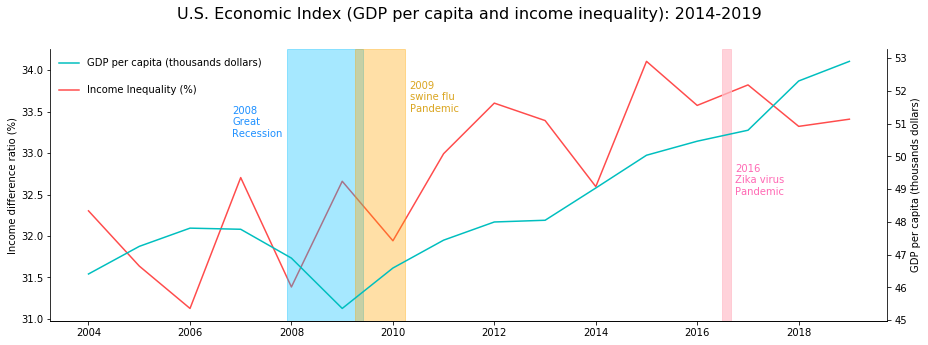

In [97]:
# Plot the changes in income inequality and GDP per capita over time
fig, ax1 = plt.subplots(figsize=(15,5))

ax1.plot(gdp_income['year'], gdp_income['income_diff'],color='red', alpha=0.7, linestyle='solid', label='Income Inequality (%)')
ax2=ax1.twinx()
ax2.plot(gdp_income['year'],gdp_income['gdp_pc'],color='c',linestyle='-',label='GDP per capita (thousands dollars)')

ax1.set_title('U.S. Economic Index (GDP per capita and income inequality): 2014-2019', fontsize=16, y=1.0, pad=30)
ax1.set_ylabel('Income difference ratio (%)')
ax2.set_ylabel('GDP per capita (thousands dollars)')

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)

time_1=dt.datetime(2007,12,1)
time_2=dt.datetime(2009,6,1)
time_3=dt.datetime(2009,4,1)
time_4=dt.datetime(2010,4,1)
time_5=dt.datetime(2016,7,1)
time_6=dt.datetime(2016,9,1)
time_7=dt.datetime(2006,11,1)
time_8=dt.datetime(2016,10,1)
time_9=dt.datetime(2010,5,1)

plt.axvspan(time_1,time_2, color='deepskyblue', alpha=0.35)
plt.axvspan(time_3,time_4, color='orange', alpha=0.35)
plt.axvspan(time_5,time_6, color='pink', alpha=0.7)


ax1.text(time_7, 33.2, '2008\nGreat\nRecession', color = 'dodgerblue') 
ax1.text(time_9, 33.5, '2009\nswine flu\nPandemic', color = 'goldenrod') 
ax1.text(time_8, 32.5, '2016\nZika virus\nPandemic', color = 'hotpink')

ax1.legend(frameon=False, loc='upper left',bbox_to_anchor=(0, 0.9))
ax2.legend(frameon=False)

plt.savefig('gdp_pc_time_series.svg')

plt.show()

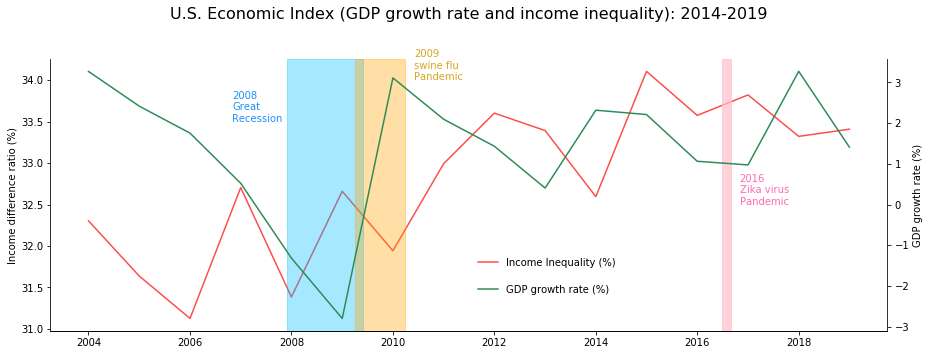

In [98]:
# Plot the changes in income inequality and GDP growth rate over time
fig, ax1 = plt.subplots(figsize=(15,5))

ax1.plot(gdp_income['year'], gdp_income['income_diff'],color='red', alpha=0.7, linestyle='solid', label='Income Inequality (%)')
ax2=ax1.twinx()
ax2.plot(gdp_income['year'],gdp_income['gdp_gr'],color='seagreen',linestyle='-',label='GDP growth rate (%)')

ax1.set_title('U.S. Economic Index (GDP growth rate and income inequality): 2014-2019', fontsize=16, y=1.0, pad=40)
ax1.set_ylabel('Income difference ratio (%)')
ax2.set_ylabel('GDP growth rate (%)')

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)

time_1=dt.datetime(2007,12,1)
time_2=dt.datetime(2009,6,1)
time_3=dt.datetime(2009,4,1)
time_4=dt.datetime(2010,4,1)
time_5=dt.datetime(2016,7,1)
time_6=dt.datetime(2016,9,1)
time_7=dt.datetime(2006,11,1)
time_8=dt.datetime(2010,6,1)
time_9=dt.datetime(2016,11,1)

plt.axvspan(time_1,time_2, color='deepskyblue', alpha=0.35)
plt.axvspan(time_3,time_4, color='orange', alpha=0.35)
plt.axvspan(time_5,time_6, color='pink', alpha=0.7)


ax1.text(time_7, 33.5, '2008\nGreat\nRecession', color = 'dodgerblue') 
ax1.text(time_8, 34, '2009\nswine flu\nPandemic', color = 'goldenrod') 
ax1.text(time_9, 32.5, '2016\nZika virus\nPandemic', color = 'hotpink')

ax1.legend(frameon=False, loc='lower left', bbox_to_anchor=(0.5, 0.2))
ax2.legend(frameon=False, loc='lower left', bbox_to_anchor=(0.5, 0.1))

plt.savefig('gdp_gr_time_series.svg', bbox_inches='tight')

plt.show()